In [213]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json
import pickle
import gzip
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class
from measures0_to_2_new import AllMeasures


from expbasics.visualizations import sum_it, data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2
plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.family': 'serif', "font.size": 14})

In [217]:
ALL_MEASURES = [
    "m0_rho",
    "m0_mi",
    "m0_phi",
    "m1_mi",
    "m1_phi",
    "m1_mlc_abs",
    "m1_mlc_cosine",
    "m2_rel_abs",
    "m2_rel_euclid",
    "m2_rel_cosine",
    "m2_mac_abs",
    "m2_mac_euclid",
    "m2_mac_euclid_weighted",
    "m2_mac_cosine",
    "m2_mac_angular",
    "m2_mac_euclid_per_image",
    "m2_mac_kernel",
    "m2_rma_sum",
    "m2_rma_weighted",
    "m2_pg_sum",
    "m2_pg_weighted",
    "m2_rra_sum",
    "m2_rra_weighted",
    "m2_bbox_rel",
    "m2_rel_kernel",
    "m1_mlc_kernel",
]

NAME_DICT = {
    "m0_rho": "Coupling Ratio $\\rho$ ($m_0$)",
    "m0_mi": "MI $corr(S,W)$ ($m_0$)",
    "m0_phi": "$\\phi$-correlation $corr(S,W)$ ($m_0$)",
    "m1_mi": "MI $corr(y,W)$ ($m_1$)",
    "m1_phi":"$\\phi$-correlation $corr(y,W)$ ($m_1$)",
    "m1_mlc_abs": "MLC absolute (= euclid) ($m_1$)",
    "m1_mlc_cosine": "MLC cosine ($m_1$)",
    "m2_rel_abs": "Relevance Vector absolute ($m_2$)",
    "m2_rel_euclid": "Relevance Vector euclid ($m_2$)",
    "m2_rel_cosine": "Relevance Vector cosine ($m_2$)",
    "m2_mac_abs": "MAC absolute ($m_2$)",
    "m2_mac_euclid": "MAC euclid ($m_2$)",
    "m2_mac_euclid_weighted": "MAC euclid weighted ($m_2$)",
    "m2_mac_cosine": "MAC cosine ($m_2$)",
    "m2_mac_angular": "MAC angular ($m_2$)",
    "m2_mac_euclid_per_image": "MAC euclid per image ($m_2$)",
    "m2_mac_kernel": "MAC kernel ($m_2$)",
    "m2_rma_sum": "RMA average ($m_2$)",
    "m2_rma_weighted": "RMA weighted ($m_2$)",
    "m2_pg_sum": "Pointing Game average ($m_2$)",
    "m2_pg_weighted": "Pointing Game weighted ($m_2$)",
    "m2_rra_sum": "RRA average ($m_2$)",
    "m2_rra_weighted":  "RRA weighted ($m_2$)",
    "m2_bbox_rel": "Relevance within bounding box ($m_2$)",
    "m2_rel_kernel": "Relevance Vector kernel ($m_2$)",
    "m1_mlc_kernel": "MLC kernel ($m_1$)",
}
enums = [
    (0, "m0_rho", 1),
    (1, "m0_mi", 1),
    (2, "m0_phi", 1),
    (3, "m1_mi", 1),
    (4, "m1_phi", 1),
    (5, "m1_mlc_abs", 1),
    (6, "m1_mlc_cosine", 1),
    (7, "m2_rel_abs", 1),
    (8, "m2_rel_euclid", 1),
    (9, "m2_rel_cosine", 1),
    (10, "m2_mac_abs", 1),
    (11, "m2_mac_euclid", 1),
    (12, "m2_mac_euclid_weighted", 1),
    (13, "m2_mac_cosine", 1),
    (14, "m2_mac_angular", 1),
    (15, "m2_mac_euclid_per_image", 1),
    (16, "m2_mac_kernel", 1),
    (17, "m2_rma_sum", 1),
    (18, "m2_rma_weighted", 1),
    (19, "m2_pg_sum", 1),  # this is highly questionable
    (20, "m2_pg_weighted", 1),
    (21, "m2_rra_sum", 1),
    (22, "m2_rra_weighted", 1),
    (23, "m2_bbox_rel", 1),
    (24, "m2_rel_kernel", 1),
    (25, "m1_mlc_kernel", 1),
]
[0, 4, 8,9,24,10,13,15,16,18,20,22,23]
ms = AllMeasures(
    "../dsprites-dataset/images/",
)

torch.Size([51, 16, 8, 4])


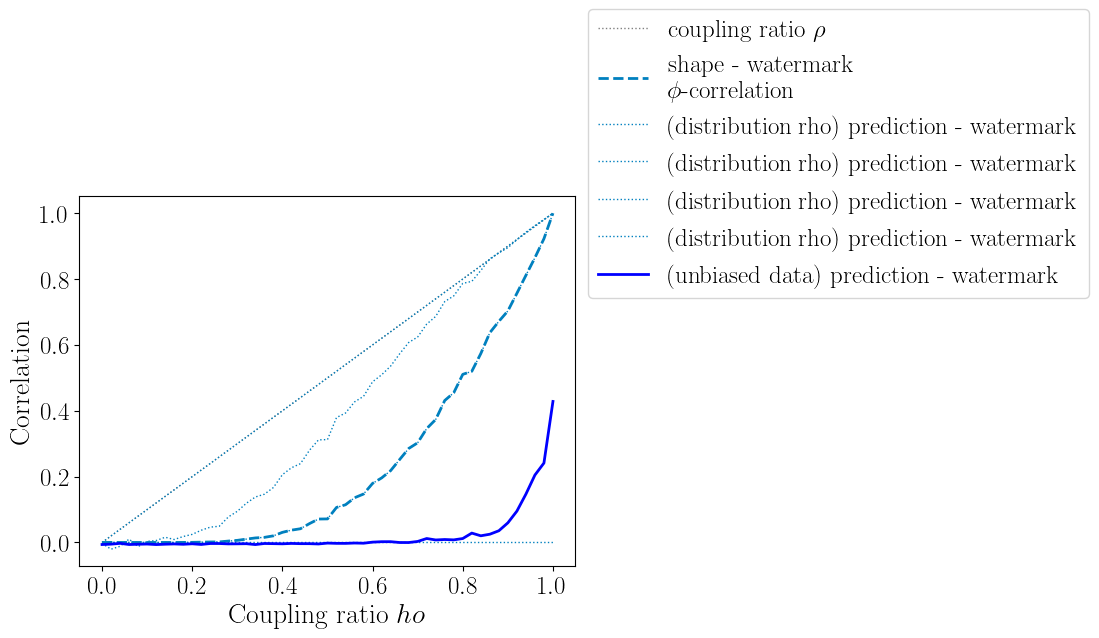

In [15]:
# Ground Truth

biases = list(np.round(np.linspace(0, 1, 51), 3))
with open("m1_mi_6400.pickle", "rb") as f:
    m1_mi = pickle.load(f)
with open("m0_test.pickle", "rb") as f: #gt_measures_1280
    gt_measures = pickle.load(f)
with open("shape_gt_6400.pickle", "rb") as f:
    shape_gt = pickle.load(f)
mimean = torch.mean(m1_mi, dim=1)
print(gt_measures.shape)

""" plt.plot(biases, torch.mean(shape_gt[:,:,0], dim=1),linewidth=2, label="MI shape", color="#f90", alpha=0.5)
plt.plot(biases, gt_measures[:,0,0],linewidth=2, label="MI true label - watermark", linestyle="dashed", color="#f00")
plt.plot(biases, torch.mean(gt_measures[:,:,2], dim=1),linewidth=1, label="MI (distribution rho) true label - watermark", linestyle="dotted", color="#f55")
plt.plot(biases, mimean[:,0],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00") """
ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))
#plt.plot(biases, torch.mean(shape_gt[:,:,1], dim=1),linewidth=2, label="shape - prediction", color=ecol[3])
plt.plot(biases, biases,linewidth=1, label="coupling ratio $\\rho$", linestyle="dotted", color="gray")
plt.plot(biases, torch.mean(gt_measures[:,:,1,0], dim=1),linewidth=2, label="shape - watermark\n $\\phi$-correlation", linestyle="dashed", color=ecol[2])
plt.plot(biases, torch.mean(gt_measures[:,:,3], dim=1),linewidth=1, label="(distribution rho) prediction - watermark", linestyle="dotted", color=ecol[2])
plt.plot(biases, mimean[:,1],linewidth=2, label="(unbiased data) prediction - watermark", color=ecol[0])

 
plt.ylabel("Correlation")
plt.xlabel("Coupling ratio $\rho$")
plt.legend(bbox_to_anchor=(1., 0.69,0.6, 0.0), loc='lower left',ncols=1, )
#(0., -0.53, 1., .102)

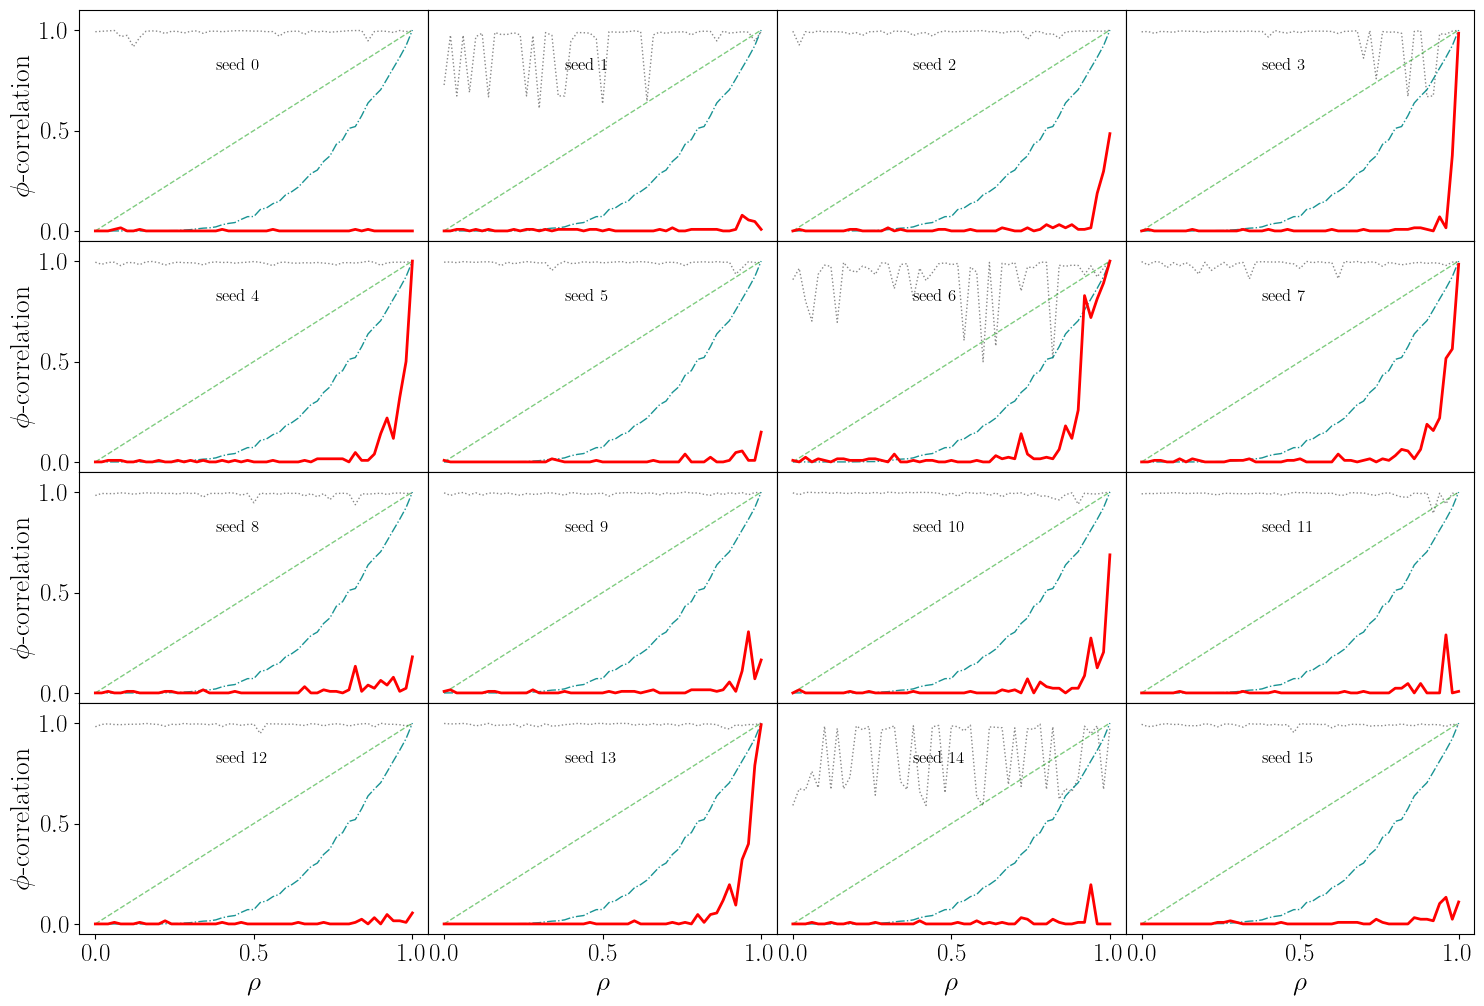

In [17]:
# MI and PHI over seeds

with open("pf_128.pickle", "rb") as f:
    m1_mi = pickle.load(f)
    
with open("outputs/retrain.json", "r") as jf:
    accuracies = json.load(jf)

def to_name(b, i):
    return "b{}-i{}".format(
        str(round(b, 2)).replace(".", "_"),
        str(i),
    )
     
biases = list(np.round(np.linspace(0, 1, 51), 3))
fig, axs = plt.subplots(
        4,
        4,
        figsize=(
            18,
            12,
        ),
        gridspec_kw={"wspace": 0.0, "hspace": 0},
    )
for s in range(16):
    names = [to_name(b, s) for b in biases]
    accuracy = np.array([accuracies[n]["train_accuracy"][2]/ 100 for n in names])
    axs[s //4, s % 4].set_ylim([-0.05, 1.1])
    axs[s //4, s % 4].set_xlabel("$\\rho$")
    axs[s //4, s % 4].set_ylabel("$\\phi$-correlation")
    if s // 4 != 3 :
        axs[s //4, s % 4].xaxis.set_visible(False)
    if s % 4 != 0:
        axs[s //4, s % 4].yaxis.set_visible(False)
    axs[s //4, s % 4].text(
        0.38, 0.8,
        f"seed {s}",
        size=12,
    )
    axs[s //4, s % 4].plot(biases, accuracy,linewidth=1,linestyle="dotted", label="accuracy", color="#888")
    axs[s //4, s % 4].plot(biases, biases,linewidth=1, label="coupling ratio $\\rho$", linestyle="dashed", color="#090", alpha=0.5)
    axs[s //4, s % 4].plot(biases, torch.mean(gt_measures[:,:,1,0], dim=1),linewidth=1, label="shape - watermark\n$\\phi$-correlation", linestyle="dashdot", color="#088", alpha=0.9)
    axs[s //4, s % 4].plot(biases, m1_mi[:,s,1],linewidth=2, label="MI (data unbiased) prediction - watermark", color="#f00")

In [18]:
with gzip.open("all_measures_128_4.pickle", "rb") as f:
    per_sample = pickle.load(f)

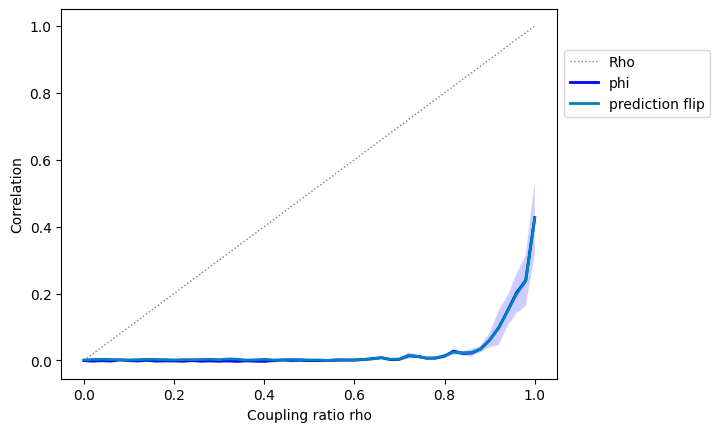

In [92]:
# Phi Correlation VS Prediction Flip
biases = list(np.round(np.linspace(0, 1, 51), 3))
with open("pf_128.pickle", "rb") as f:
    pf_128 = pickle.load(f)

mimean = torch.mean(per_sample[:, :, 0, 4], dim=1)
pf_128_mean = torch.mean(pf_128, dim=1)
plt.plot(biases, biases, linewidth=1, label="Rho", linestyle="dotted", color="gray")
ecol = matplotlib.cm.winter(np.linspace(0, 1, 5))

plt.plot(biases, mimean, linewidth=2, label="phi", color=ecol[0])
sigmaphi = torch.std(per_sample[:, :, 0, 4], dim=1) / math.sqrt(16)
plt.fill_between(
    biases,
    mimean + sigmaphi,
    mimean - sigmaphi,
    facecolor=ecol[0],
    alpha=0.1,
)

plt.plot(biases, pf_128_mean[:, 0], linewidth=2, label="prediction flip", color=ecol[2])
sigmapf = (torch.std(pf_128[:, :, 0], dim=1) / math.sqrt(16))[:, 0]
plt.fill_between(
    biases,
    pf_128_mean[:, 0, 0] + sigmapf,
    pf_128_mean[:, 0, 0] - sigmapf,
    facecolor=ecol[0],
    alpha=0.1,
)
plt.ylabel("Correlation")
plt.xlabel("Coupling ratio rho")
plt.legend(
    bbox_to_anchor=(1.0, 0.69, 0.6, 0.0),
    loc="lower left",
    ncols=1,
)

In [47]:
# TEST MEASURES FOR PREDICTIONS
import gzip

softmax = torch.nn.Softmax(dim=1)
sizes = []
bias_arr = range(0, 51)
softmaxhm = torch.nn.Softmax(dim=1)
for b in bias_arr:
    filename = f"outputs/measures/{b}_{6}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    pred0s = r_m_info[1][:, 0].to(dtype=torch.float)
    pred1s = r_m_info[1][:, 1].to(dtype=torch.float)
    maxval = max(pred0s.max(), pred1s.abs().max())

    pred0sabs = softmax(pred0s)
    pred1sabs = softmax(pred1s)
    sizes.append(
        [
            torch.mean(torch.sum(torch.abs(pred1sabs - pred0sabs), dim=1) / 2),
            torch.mean(
                (
                    1
                    - torch.nn.functional.cosine_similarity(
                        pred1sabs,
                        pred0sabs,
                        dim=1,
                    )
                )
            ),
            torch.mean(
                torch.sum(
                    torch.square(pred1sabs)
                    - 2 * (pred1sabs * pred0sabs)
                    + torch.square(pred0sabs),
                    dim=(1),
                )
            )
            / 2,
            torch.arccos(
                torch.nn.functional.cosine_similarity(
                    pred1sabs.flatten(), pred0sabs.flatten(), dim=0
                )
            )
            / math.pi,
        ]
    )
labels = ["mlc_abs", "mlc_cosine", "mlc_kernel", "mlc_angular"]

In [41]:
# TEST MEASURES FOR RELEVANCES
sizes = []
bias_arr = range(0, 51)
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
softmaxhm = torch.nn.Sigmoid()
for b in bias_arr:
    filename = f"outputs/measures/{b}_{10}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    """    divby = torch.count_nonzero(torch.var(torch.cat((rels1, rels0)), dim=0) > 0.001)
    maxval =  max(
                    rels0.abs().max(),
                    rels1.abs().max(),
                )
    only_indices = torch.var(torch.cat((rels1, rels0)), dim=0) > 0.001
    print( maxval,divby, maxval * divby, torch.var(torch.cat((rels1, rels0)), dim=0) > 0.001) """
    sizes.append(
        [
            torch.mean(torch.sum(torch.abs(rels1 - rels0), dim=1)) / 2,
            ms.euclidean_distance(rels1, rels0) / np.sqrt(128),
            torch.mean(torch.sqrt(torch.sum(((rels1 - rels0) ** 2), dim=1))),
            torch.mean(
                (
                    1
                    - torch.nn.functional.cosine_similarity(
                        rels1.flatten(),
                        rels0.flatten(),
                        dim=0,
                    )
                )
            ),
            torch.arccos(
                torch.nn.functional.cosine_similarity(
                    rels1.flatten(), rels0.flatten(), dim=0
                )
            )
            / math.pi,
            torch.mean(
                torch.sum(
                    torch.square(rels1) - 2 * (rels1 * rels0) + torch.square(rels0),
                    dim=(1),
                )
                / 2
            ),
        ]
    )
labels = [
    "m2_rel_abs",
    "m2_rel_euclid_all",
    "m2_rel_euclid",
    "m2_rel_cosine",
    "m2_rel_angular",
    "m2_rel_kernel",
]
# imgify(hm1s[60],resize=800, grid=(1,8))
# my_plot_grid(torch.cat((hm1s[70:71], hm0s[70:71])),2, 8, resize=3, norm=True)
# rels1.abs().mean(dim=(0)).tolist(), rels0.abs().mean(dim=(0)).tolist()

In [243]:
# TEST MEASURES WITH MAC HEATMAP
import gzip

sizes = []
bias_arr = range(0, 1)
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
softmaxhm = torch.nn.Softmax(dim=1)
for b in bias_arr:
    filename = f"outputs/measures/5{b}_{6}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    hm0s = r_m_info[0][:, 0].to(dtype=torch.float64)
    hm1s = r_m_info[0][:, 1].to(dtype=torch.float64)
    # rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    weights = rels1.abs()
    maxval = max(
        hm0s.abs().sum(dim=(1, 2, 3)).max(),
        hm1s.abs().sum(dim=(1, 2, 3)).max(),
        # torch.max(hm0s.abs(),dim=0).values.max() * 128,
        # torch.max(hm1s.abs(),dim=0).values.max()* 128,
    )

    # only_non_zeros = np.where(np.logical_or(hm0s != 0 , hm1s != 0 ))
    # print(len(only_non_zeros[0]))
    hm0sabs = hm0s / (
        maxval
    )  # (hm0s.abs().sum(dim=(1, 2, 3))[:,None,None,None] + 1e-10)#(maxval)
    hm1sabs = hm1s / (
        maxval
    )  # (hm1s.abs().sum(dim=(1, 2, 3))[:,None,None,None]+ 1e-10)#(maxval)
    """ hm0sabs = hm0s[only_non_zeros]
    hm1sabs = hm1s[only_non_zeros]
    len_non_zero = len(only_non_zeros[0]) """
    sizes.append(
        np.array(
            [
                torch.mean(
                    torch.tensor(
                        [ms.kernel_distance(hm1s[n], hm0s[n]) for n in range(128)]
                    )
                ),
                torch.mean(
                    torch.sum(
                        torch.sqrt(
                            torch.sum(torch.square((hm1sabs - hm0sabs)), dim=(2, 3))
                        ),
                        dim=1,
                    )
                ),
            ]
        )
    )
labels = [
    "m2_mac_kernel",
    "m2_mac_kernel_weighted",
    "m2_mac_euclid",
    "m2_mac_euclid_weighted",
]

with open("sizes.pickle", "wb") as f:
    pickle.dump(sizes, f)

tensor(13.6800, dtype=torch.float64) tensor([ 0.1598, -0.0238,  0.0000,  0.0374,  0.0443,  0.0701,  0.2474,  0.1896])


In [ ]:
# TEST MEASURES WITH HEATMAP MASKED
sizes = []
bias_arr = range(0, 51)
indices = np.round(np.linspace(0, 491519, 128)).astype(int)
softmaxhm = torch.nn.Softmax(dim=1)
for b in bias_arr:
    filename = f"outputs/measures/{b}_{13}.gz"
    with gzip.open(filename, mode="rb") as f:
        r_m_info = pickle.load(f)
    hm0s = r_m_info[0][:, 0].to(dtype=torch.float)
    hm1s = r_m_info[0][:, 1].to(dtype=torch.float)
    rels0 = r_m_info[2][:, 0].to(dtype=torch.float)
    rels1 = r_m_info[2][:, 1].to(dtype=torch.float)
    (
        m2_rma_sum,
        m2_rma_weighted,
        m2_pg_sum,
        m2_pg_weighted,
        m2_rra_sum,
        m2_rra_weighted,
        m2_bbox_rel,
        rma_total,
    ) = (0, 0, 0, 0, 0, 0, 0, 0)
    for n, ind in enumerate(indices):
        wm_mask = ms.ds.load_watermark_mask(ind)
        """ _, _, offset = ms.ds.get_item_info(ind)
        mask = torch.zeros(64, 64).to(ms.tdev)
        mask[
            max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
            max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
        ] = 1 """

        weight = rels1[n]
        hms_values1 = ms.heatmap_values(hm1s[n], wm_mask)
        hms_values0 = ms.heatmap_values(hm0s[n], wm_mask)
        divby =  max(1, int(hms_values1["non_empty"]), int(hms_values0["non_empty"]))
        # pure rma summed
        m2_rma_sum += (
            torch.sum(torch.abs(hms_values1["rma"] - hms_values0["rma"])) / divby
        )
        # rma weighted sum
        m2_rma_weighted += torch.sum(
            torch.abs((hms_values1["rma"] - hms_values0["rma"]) * weight)
        )
        # pg sum
        m2_pg_sum += torch.sum(torch.abs(hms_values1["pg"] - hms_values0["pg"])) / divby
        # pg weighted sum
        m2_pg_weighted += torch.sum(
            torch.abs((hms_values1["pg"] - hms_values0["pg"]) * weight)
        )
        # rra sum
        m2_rra_sum += (
            torch.sum(torch.abs(hms_values1["rra"] - hms_values0["rra"])) / divby
        )
        # rra weighted sum
        m2_rra_weighted += torch.sum(
            torch.abs((hms_values1["rra"] - hms_values0["rra"]) * weight)
        )
        # relevance within summed
        m2_bbox_rel += torch.sum(
            torch.abs(hms_values1["rel_within"] - hms_values0["rel_within"])
        ) / max(1, int(hms_values1["non_empty"]), int(hms_values0["non_empty"]))

    sizes.append(
        np.array(
            [
                m2_rma_sum / 128,
                m2_rma_weighted / 128,
                m2_pg_sum / 128,
                m2_pg_weighted / 128,
                m2_rra_sum / 128,
                m2_rra_weighted / 128,
                m2_bbox_rel / 128,
            ]
        )
    )

labels = [
    "m2_rma_sum",
    "m2_rma_weighted", 
    "m2_pg_sum",
    "m2_pg_weighted",
    "m2_bbox_rel", "m2_rra_sum",
    "m2_rra_weighted",
]


with open("sizes.pickle", "wb") as f:
    pickle.dump(sizes, f)
# imgify(hm1s[60],resize=800, grid=(1,8))
# my_plot_grid(torch.cat((hm1s[70:71], hm0s[70:71])),2, 8, resize=3, norm=True)
# rels1.abs().mean(dim=(0)).tolist(), rels0.abs().mean(dim=(0)).tolist()

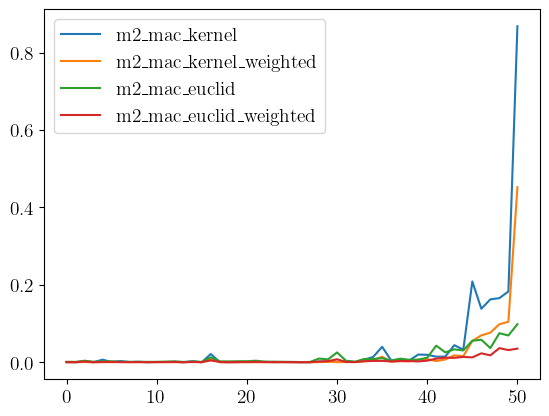

In [228]:
# TEST PLOT NORMALIZED VALUES TEST
with open("sizes.pickle", "rb") as f:
    sizes = pickle.load(f)
for meas in range(len(labels)): # [0,1,2,3,4,5,6]: #
    vals = np.array([a[meas] for a in sizes])
    #vals = vals / vals.max()
    plt.plot(bias_arr, vals, label=labels[meas])
plt.legend()

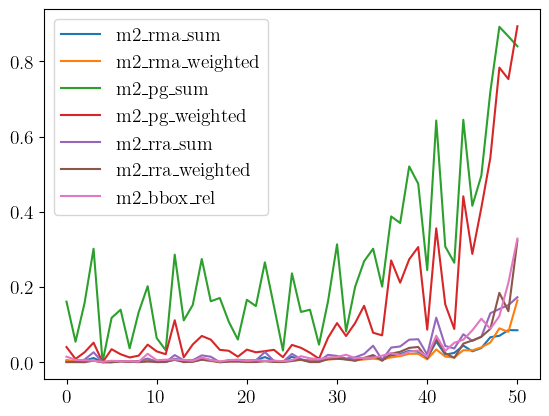

In [162]:
# TEST PLOT NORMALIZED VALUES TEST
with open("sizes1.pickle", "rb") as f:
    sizes = pickle.load(f)
for meas in range(len(labels)): # [0,1,2,3,4,5,6]: #
    vals = np.array([a[meas] for a in sizes])
    #vals = vals / vals.max()
    plt.plot(bias_arr, vals, label=labels[meas])
plt.legend()

In [210]:
tst1 = torch.zeros((128, 8, 64 * 64))
tst2 = torch.zeros((128, 8, 64 * 64))
tst2[:, :, 0:18] = (torch.rand(128) * 100)[:,None,None]
tst2[:, :, 40:80] = 10
tst1[:, :, 40:80] = 10
softmax = torch.nn.Softmax(dim=2)
tst1 = softmax(tst1)
tst2 = softmax(tst2)
maxval = max(
    tst1.sum(dim=(1, 2)).max(),
    tst2.sum(dim=(1, 2)).max(),
)

def kernel2d(a, b):
    return (
        torch.nn.functional.conv2d(a, a)
        - 2 * torch.nn.functional.conv2d(a, b)
        + torch.nn.functional.conv2d(b, b)
    )


def kernel_distance(v0, v1):
    batched = kernel2d(
        v1.view(8, 1, 64, 64),
        v0.view(8, 1, 64, 64),
    )
    print(torch.sum(torch.tensor([batched[i, i] for i in range(8)])))
    return torch.sum(torch.diagonal(batched, 0)) 



kernel_distance(tst1[0], tst2[0])

tensor(0.6425)


tensor(0.6425)

In [204]:

kernel_distance(tst1[57], tst2[57])

[tensor(0.0803), tensor(0.0803), tensor(0.0803), tensor(0.0803), tensor(0.0803), tensor(0.0803), tensor(0.0803), tensor(0.0803)] tensor([[[0.0803, 0.0803, 0.0803, 0.0803, 0.0803, 0.0803, 0.0803, 0.0803]]])


tensor(0.6426)

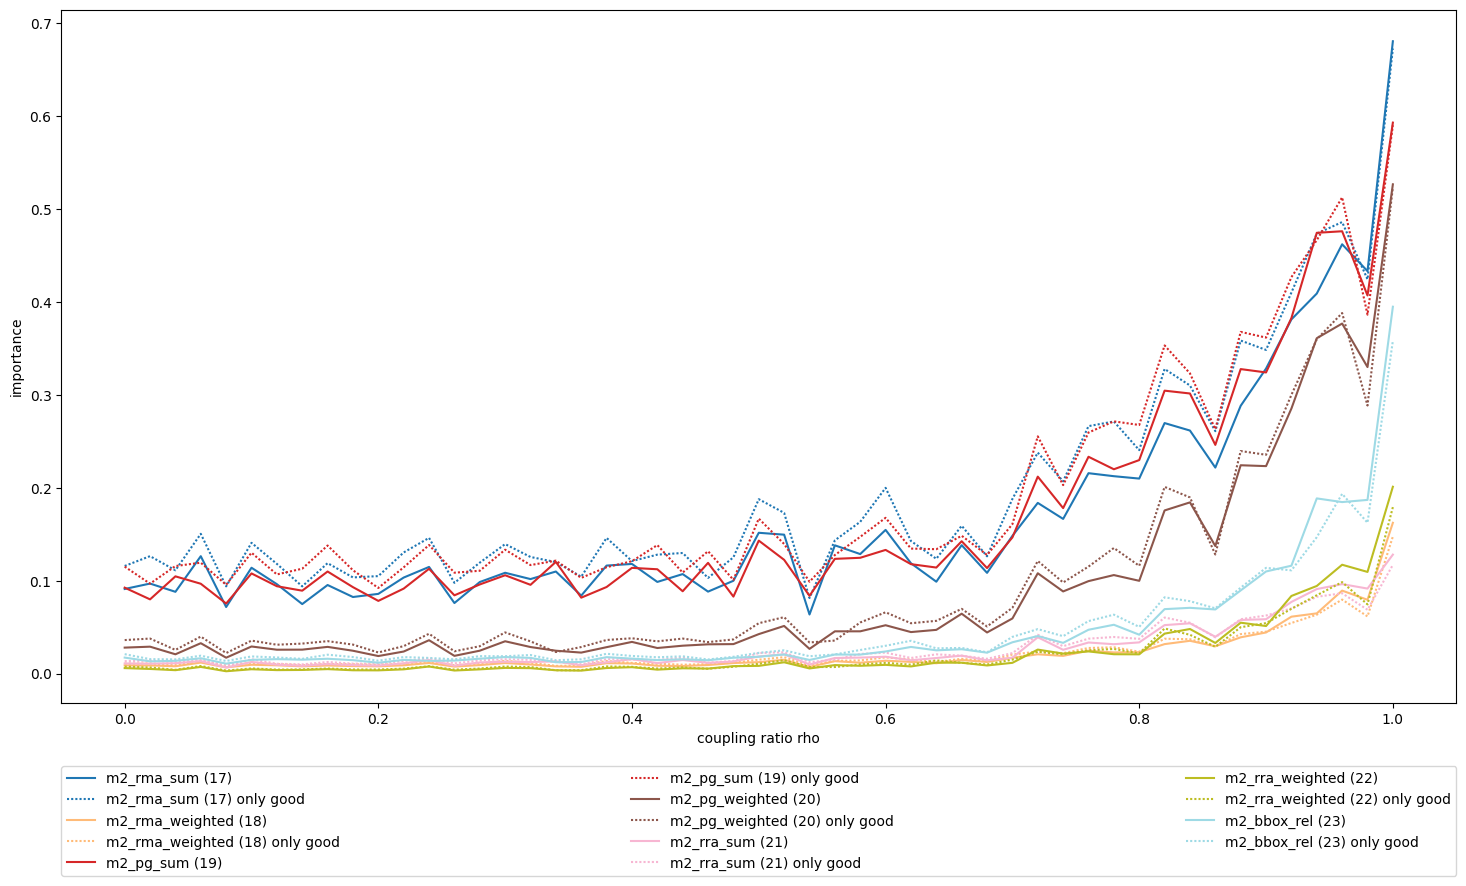

In [83]:
# FILTER BAD OUT
def filter_bad_out(data):
    filtered = torch.zeros(51,12,128,26)
    c = 0
    for num_it in range(16):
        if num_it not in [6,14, 1,3,]: #1,3,
            filtered[:, c] = data[:,num_it,:,:]
            c+=1
    return filtered
filtered = filter_bad_out(per_sample)

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = range(17,24)
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(per_sample, dim=(1,2))
per_rho_good = torch.mean(filtered, dim=(1,2))
#normalized = per_rho / torch.max(per_rho, dim=0).values

colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    #for s in range(16):
    l = ALL_MEASURES[i]
    label = f"{l} ({i})" #if s == 0 else ""
    vals = per_rho[:,i] 
    vals_good = per_rho_good[:,i]

    if  l: #.startswith("m2_mac") #"bbox" in l or "kernel" in
        plt.plot(
            biases,
            vals,
            label=label,
            linestyle=ls[int(l[1])],
            c=colors[en],
        )  
        plt.plot(
            biases,
            vals_good,
            label=f"{label} only good",
            linestyle=(0, (1, 1)),
            c=colors[en],
        ) 

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


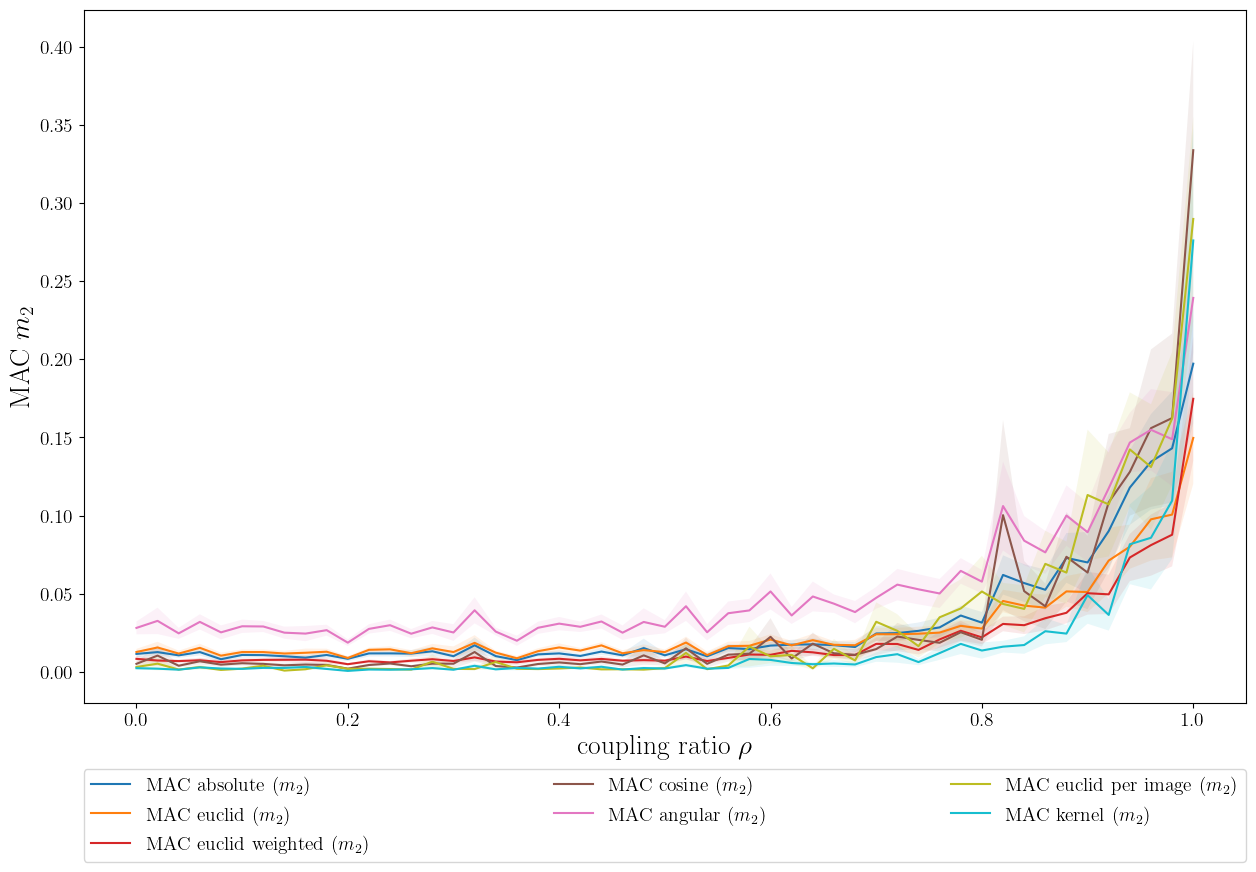

In [140]:
# SHOW CERTAIN MEASURES
import collections.abc

def draw_measures(per_sample, ptype="all", with_title = False):
    variable_options = {
        "m0": [range(0,3), "data distribution for only 128 samples $m_0$", "correlation", -0.14,3],
        "m1": [[3,4,5,6,25], "Ground Truth Model Importance $m_1$", "model importance $m_1$", -0.18, 3],
        "m2_mac": [range(10,17), "Mean Attribution Change (comparing distance metrics) $m_2$", "MAC $m_2$", -0.23,3],
        "m2_region": [range(17,24), "Region specific metrics $m_2$", "region-specific change $m_2$", -0.23,3],
        "m2_rel": [[7,8,9,24], "Relevance Vector (comparing distance metrics) $m_2$", "relevance vector change $m_2$", -0.18, 2],
        "abs": [[5,7,10,18,20,22,23], "Absolute Measures $m_2$", "absolute change $m_2$", -0.22,3],
        "kernel": [[16,24,25], "Kernelized Treatment Effect $m_2$", "kernelized change $m_2$", -0.14,3],
        "euclid": [[5,8,11,12,15], "Euclidean Distance Measures $m_2$", "euclidean change $m_2$", -0.18,3],
        "avg_vs_weigh": [[17,18,19,20,21,22], "Averaged vs. Weighted region-specific Measures $m_2$", "region-specific change $m_2$", -0.18,3],
        "cosine": [[6,9,13,14], "Cosine Distance Measures $m_2$", "cosine change $m_2$", -0.14,4],
        "all": [range(len(ALL_MEASURES)), "All Measures $m_0,m_1,m_2$", "all measures", -0.48,3],
        "chosen": [[4,5,6,25,16,23,24,6,9,13,14], "All Chosen Metrics","all", -0.33, 3]
    }
    
    if not isinstance(ptype, str):
        plot_variables = [[ALL_MEASURES.index(n) for n in ptype],"comparison","change",-0.14,1]
    elif ptype in variable_options:
        plot_variables = variable_options[ptype]
    else:
        plot_variables = [[ALL_MEASURES.index(ptype)],NAME_DICT[ptype],"change",-0.14,1]
    biases = list(np.round(np.linspace(0, 1, 51), 3))
    used_measures = plot_variables[0]
    ls = ["dotted", "dashed", "solid"]
    per_seed = torch.mean(per_sample, dim=2)  # filtered
    normalization = torch.tensor([a[2] for a in enums])
    per_seed = per_seed / normalization
    colors = matplotlib.cm.tab10(np.linspace(0, 1, len(used_measures)))
    plt.figure(figsize=(15, 9))
    for en, i in enumerate(used_measures):
        l = ALL_MEASURES[i]
        label = NAME_DICT[l]  
        linestyle = ls[int(l[1])]
        vals = torch.mean(per_seed[:, :, i], dim=1)
        sigma = torch.std(per_seed[:, :, i], dim=1) / math.sqrt(16)
        #vmin = torch.min(per_seed[:, :, i], dim=1).values
        #vmax = torch.max(per_seed[:, :, i], dim=1).values
        if l: 
            plt.plot(
                biases,
                vals,
                label=label,
                linestyle=linestyle,
                c=colors[en],
            )

            plt.fill_between(
                biases,
                vals + sigma,
                vals - sigma,
                facecolor=colors[en],
                alpha=0.1,
            )
    if with_title:
        plt.title(plot_variables[1])
    plt.ylabel(plot_variables[2])
    plt.xlabel("coupling ratio $\\rho$")
    plt.legend(
        bbox_to_anchor=(0.0, plot_variables[3], 1.0, 0.102),
        loc="lower left",
        ncols=plot_variables[4],
        mode="expand",
        borderaxespad=0.0,
    )
draw_measures(per_sample, "m2_mac")

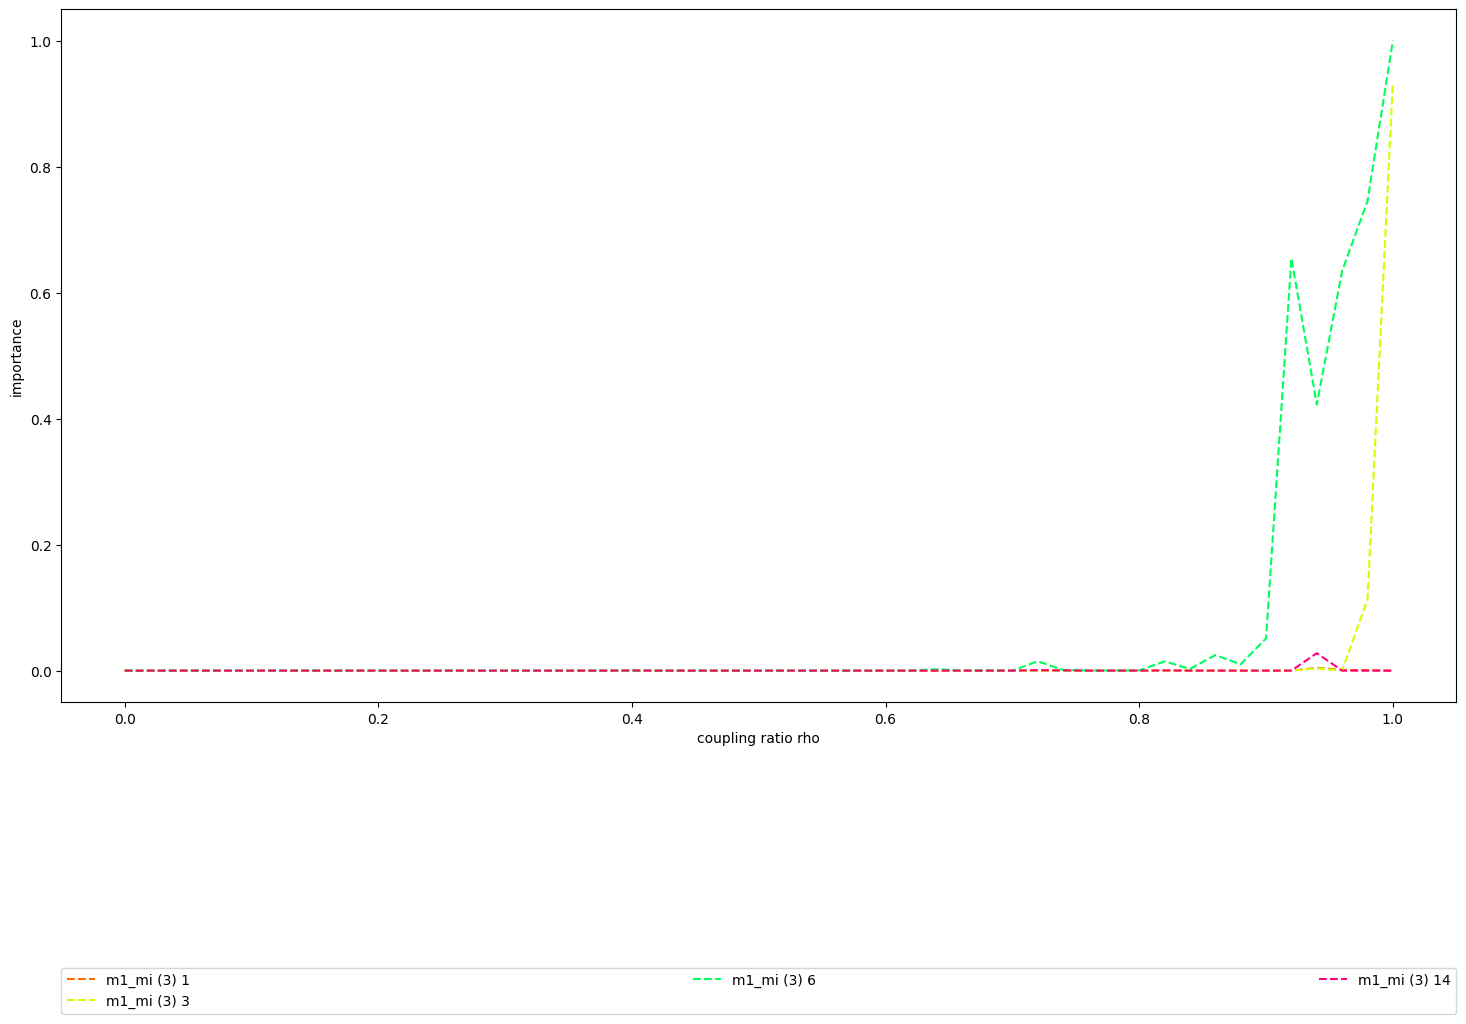

In [207]:
# MEASURES OVER SINGLE SEEDS

biases = list(np.round(np.linspace(0, 1, 51), 3))
takeing = [3]#,12,16,18, 20] #range(len(ALL_MEASURES))
ls = ["dotted", "dashed", "solid"]
per_rho = torch.mean(per_sample, dim=(2))

#colors = matplotlib.cm.tab20(np.linspace(0, 1, len(takeing)))
colors = matplotlib.cm.hsv(np.linspace(0, 1, 16))
use_m = []
plt.figure(figsize=(18,9))
for en, i in enumerate(takeing):
    for num in [1,3,6,14]:
        l = ALL_MEASURES[i]
        label = f"{l} ({i}) {num}"
        vals = per_rho[:,num, i] / enums[i][2] 
        if  l: #.startswith("m2_mac")
            plt.plot(
                biases,
                vals,
                label=label,
                linestyle=ls[int(l[1])],
                c=colors[num],
            )  

#plt.title("All measures summed over samples and seeds")
plt.ylabel("importance")
plt.xlabel("coupling ratio rho")
plt.legend(bbox_to_anchor=(0., -0.45, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0.)


In [37]:
per_sample = torch.zeros(
            (51, 16, 128, 26))
        
with gzip.open("all_measures_128_3.pickle", "rb") as f:
    old_values = pickle.load(f)
per_sample[:, :, :, :24] = old_values
with gzip.open("all_measures_128_4.pickle", "rb") as f:
    new_values = pickle.load(f)
per_sample[:, :, :, 24:] = new_values[:,:,:,24:]

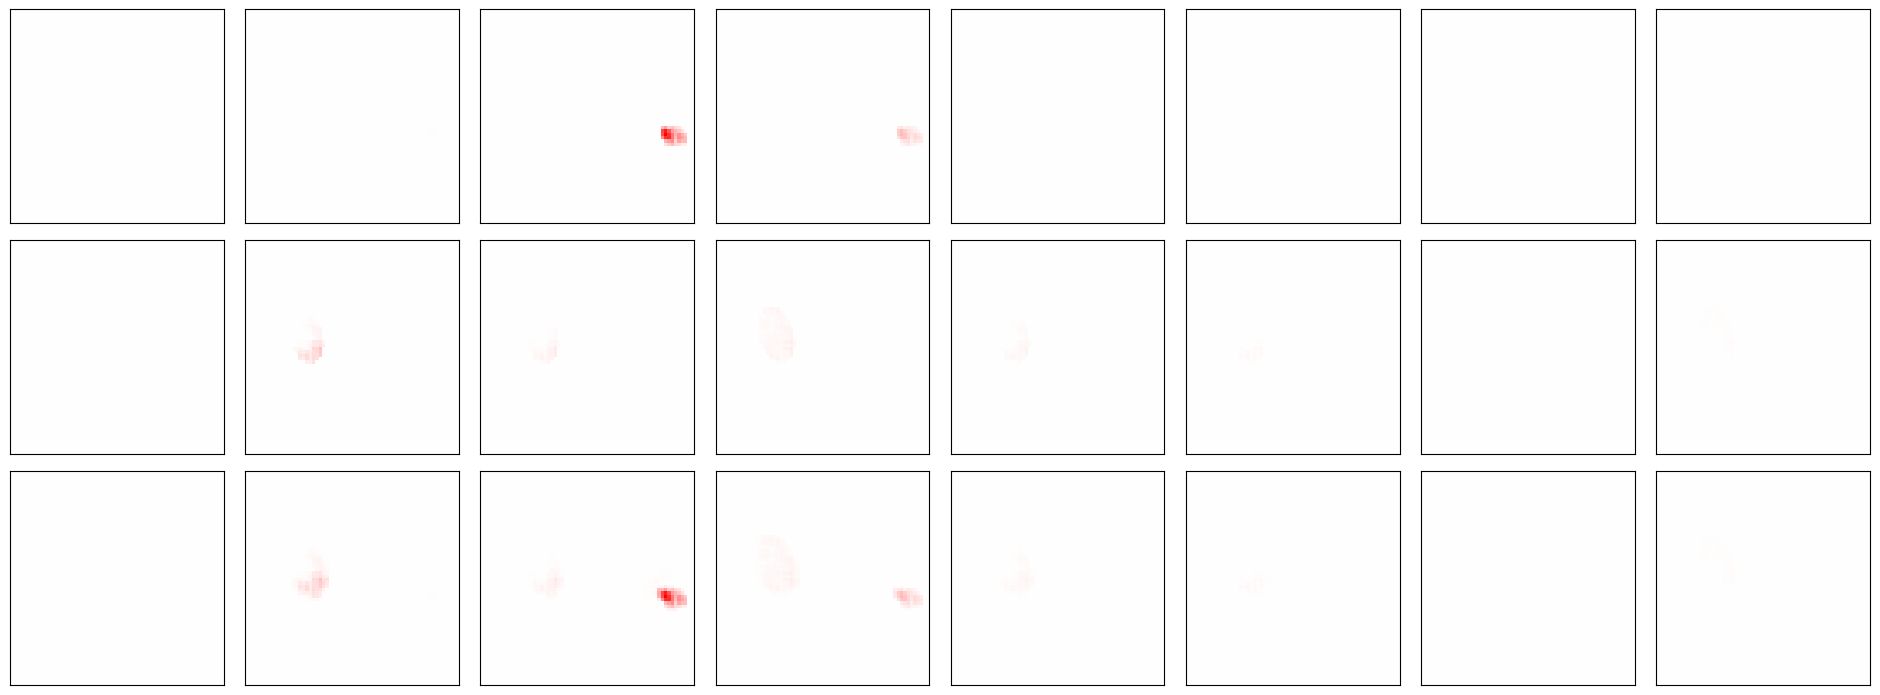

In [858]:
from measures0_to_2 import AllMeasures

bias = 1.0
num_it = 2
name = to_name(bias, num_it)
NAME = "../clustermodels/final"
ms = AllMeasures("../dsprites-dataset/images/", 5)
layer_name = "convolutional_layers.6"
index = 359500
model = load_model(NAME, bias, num_it)
crpa = CRPAttribution(model, ms.ds, "test", name)

image = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

lat, _, offset = ms.ds.get_item_info(index)

wm_mask = torch.zeros(64, 64)
wm_mask[
    max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
    max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
] = 1
shape_mask = ms.ds.load_shape_mask(index)
nlen = 8
conditions = [{layer_name: [i]} for i in crpa.layer_id_map[layer_name]]
res = 0.0

images = torch.zeros(3, nlen, 64, 64)
for attr in crpa.attribution.generate(
    image,
    conditions,
    crpa.composite,
    start_layer="linear_layers.2",
    record_layer=crpa.layer_names,
    verbose=False,
    batch_size=nlen,
):
    heatmaps_abs = attr.heatmap.abs()
    total_rel = torch.sum(heatmaps_abs, dim=(1, 2))
    images[0, :, :, :] = heatmaps_abs * wm_mask #+ 0.01 * wm_mask
    images[1, :, :, :] = heatmaps_abs * shape_mask[0]
    images[2, :, :, :] = heatmaps_abs
    wm_rel = torch.sum(heatmaps_abs * wm_mask, dim=(1, 2))
    shape_rel = torch.sum(heatmaps_abs * shape_mask[0], dim=(1, 2))
    vals = torch.zeros(nlen)
    for i in range(nlen):
        if wm_rel[i] > (shape_rel[i] * (wm_mask.sum() / (shape_mask.sum()))):
            vals[i] = wm_rel[i]
        else:
            vals[i] = 0
images = images.detach()
my_plot_grid(images, 3, nlen, resize=3, norm=True)

In [93]:
image1 = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

diff_heatmaps = torch.zeros(2, nlen, 64, 64)
hm1 = ms.heatmaps(image1, crpa)
hm0 = ms.heatmaps(image0, crpa)

predv_0 = model(image0)
predv_1 = model(image1)

diff_heatmaps[0, :, :, :] = hm1
diff_heatmaps[1, :, :, :] = hm0
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)
def kernel(a,b):
    return torch.nn.functional.conv2d(a, a) - 2*torch.nn.functional.conv2d(a, b) + torch.nn.functional.conv2d(b, b) 
def kernel1d(a,b):
    return torch.nn.functional.conv1d(a, a) - 2*torch.nn.functional.conv1d(a, b) + torch.nn.functional.conv1d(b, b) 

truediff = kernel(wm_mask.view(1,1,64,64), shape_mask.view(1,1,64,64)) 
diffs = []
predv_0, predv_1 = predv_0 / 6.1175, predv_1 / 6.1175
print(predv_0 , predv_1 ,kernel1d(predv_0.view(1,1,2),predv_1.view(1,1,2)), ms.euclidean_distance(predv_1, predv_0))
batched = kernel(hm1.view(nlen,1,64,64), hm0.view(nlen,1,64,64))
#print(float(truediff), [float(batched[i,i].flatten()) for i in range(8)], sum([float(batched[i,i].flatten()) for i in range(8)]))
#my_plot_grid(diff_heatmaps, 2, nlen, resize=3, norm=True)


tensor([[ 0.6487, -0.1161]], grad_fn=<DivBackward0>) tensor([[-0.4496,  0.8052]], grad_fn=<DivBackward0>) tensor([[[2.0548]]], grad_fn=<AddBackward0>) 1.4334536790847778


tensor(0.1410)


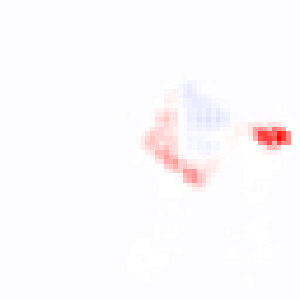

In [94]:
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient


data = torch.randn(1, 3, 224, 224)
input_img = image1
composite = EpsilonPlusFlat()

with composite.context(model) as modified_model:
    output = modified_model(input_img)
    # gradient/ relevance wrt. class/output 0tensor(0.1172)
￼
tensor(3.7253e-09)
￼
' print(list(enumerate(ALL_MEASURES)))\nbiases = list(np.round(np.linspace(0, 1, 51), 3)) '
<matplotlib.legend.Legend at 0x7f80a3e564d0>
￼
￼
torch.Size([51, 16, 128, 22]) torch.Size([51, 22])
torch.Size([51, 22])
<matplotlib.legend.Legend at 0x7f8099b1bdc0>
￼
￼
    output.backward(gradient=torch.eye(2)[[1]])
vmax = input_img.grad.max()
print(vmax)
imgify(input_img.grad[0, 0], vmax=vmax, vmin=-vmax, resize=300)

tensor(0.1172)


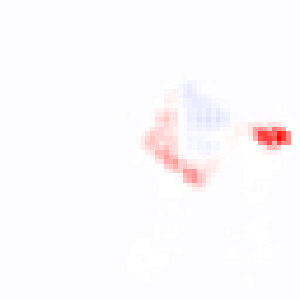

In [95]:
summed_hms = torch.sum(hm1 , dim=0)
vmaxhm = summed_hms.max()
print(vmaxhm)
imgify(summed_hms, vmax=vmaxhm, vmin=-vmaxhm, resize=300)

tensor(3.7253e-09)


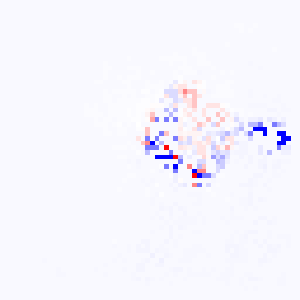

In [97]:
res = summed_hms * (vmax / vmaxhm) - input_img.grad[0, 0]
resmax = res.max()
print(resmax)
imgify(res, vmax=resmax, vmin=-resmax, resize=300)

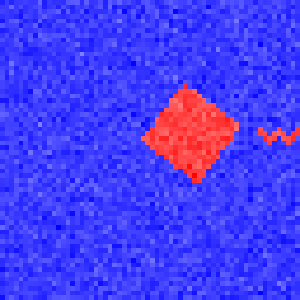

In [107]:
imgify(image1[0,0],resize=300)

In [272]:
bs = BiasedNoisyDataset()
len(bs.labels)

737280

In [274]:
737280 // 3

245760